<a href="https://colab.research.google.com/github/MaidinuerSaimi/Python-courses/blob/main/%E2%80%9CWorkshop_2_3_and_assignment_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop 2.3 (and Assignment)

In this workshop you will be putting all the pieces we learnt over the last week-and-a-half together - from basic Python, via data exploration and cleaning all the way up to modeling and evaluation.

We will start with a workshop, which will get you going.  This is followed by this week's assignment, which you are asked to work on in pairs, and submit by end of Sunday.

We will cover the following topics in today's workshop:

* Data cleaning revisited
* Pipelines
* Baseline model
* Mean Squared Error as figure of merit
* Cross validation
* Improving model fit through variable transformations and nonlinear terms

## Workshop 2.3

The first bit of code implements all that we have learnt about this data in the session on Monday;
in particular, the rounding of heights to whole feet, the excess of tall people, and the systematic
issues with the AVD measurements in the period 2003-2007.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
## If you're running this on Google Colab, use this to upload your file:

from google.colab import files
files.upload();  ## Upload 'Heart valve dissection data.csv'

Saving Heart valve dissection data.csv to Heart valve dissection data.csv


In [34]:
## Load your data.
## (If you're running Jupyter and the data is not in the directory where you started Jupyter, modify the path below)
df = pd.read_csv("Heart valve dissection data.csv")

## Drop the superfluous index columns
df = df.drop(['Unnamed: 0','Id'], axis=1)

## Remove rows with missing AVD values - we want to predict this, so imputation is not an option
df = df.loc[pd.notnull(df.AVD), :]

## set column type, otherwise it is interpreted as a string
df.loc[:,"dissection_date"] = pd.to_datetime(df["dissection_date"])

## remove people with imprecisely measured height
df = df[ (df.Height_cm != 91.44) & (df.Height_cm != 121.92) ]

## remove very tall people
df = df.loc[ df["Height_cm"] < 198, : ]

## remove people between the two dates that show an unexplained downward trend in residuals
df = df.loc[ (df["dissection_date"]>pd.Timestamp(2007,7,1)) | (df["dissection_date"] < pd.Timestamp(2003,1,1)), :]

Make a histogram plot of `Height_cm` to check that the issue of rounding towards
whole feet is now much improved.  Use `binwidth=1`.

Also make a two-dimensional histogram of `Height_cm` against `Age` to check that excess of tall people issue has
been resolved.  For a good visualisation, use parameters `binwidth=(1,3), cbar=True, norm=mpl.colors.LogNorm(), vmin=None, vmax=None, cmap="RdYlGn_r"`.



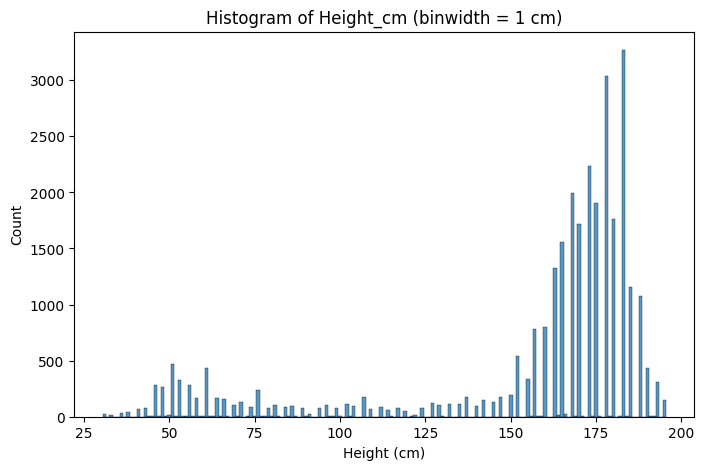

In [35]:
# Make a histogram plot of Height_cm to check that the issue of rounding towards whole feet is now much improved. Use binwidth=1；
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="Height_cm", binwidth=1)

plt.xlabel("Height (cm)")
plt.ylabel("Count")
plt.title("Histogram of Height_cm (binwidth = 1 cm)")
plt.show()


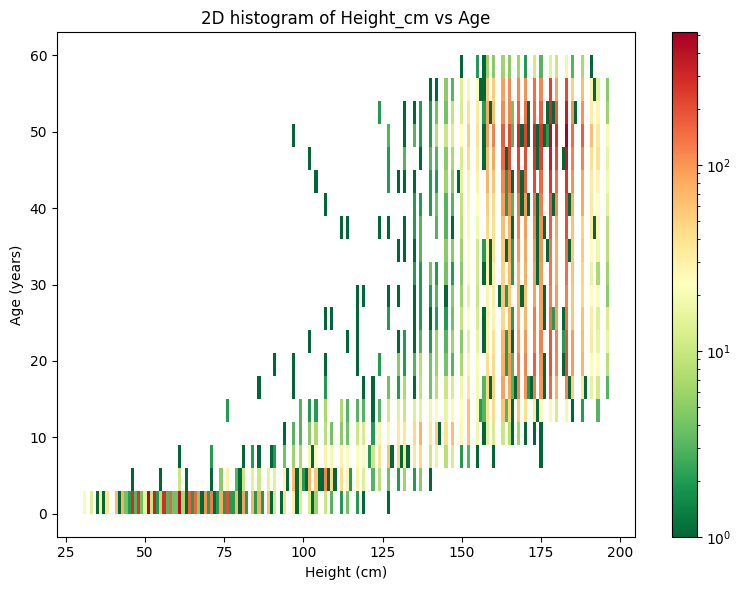

In [36]:
#Also make a two-dimensional histogram of Height_cm against Age to check that excess of tall people issue has been resolved. For a good visualisation, use parameters binwidth=(1,3), cbar=True, norm=mpl.colors.LogNorm(), vmin=None, vmax=None, cmap="RdYlGn_r".
plt.figure(figsize=(8, 6))

sns.histplot(
    data=df,
    x="Height_cm",
    y="Age",
    binwidth=(1, 3),                 # Height 用 1 cm 的宽度，Age 用 3 年的宽度
    cbar=True,                       # 右边显示 colorbar
    norm=mpl.colors.LogNorm(),       # 颜色用 log 规范化，更容易看稀疏区域
    vmin=None,
    vmax=None,
    cmap="RdYlGn_r"                  # 红-黄-绿 反转色图，绿 = 低，红 = 高
)

plt.xlabel("Height (cm)")
plt.ylabel("Age (years)")
plt.title("2D histogram of Height_cm vs Age")
plt.tight_layout()
plt.show()

To slowly segue from data exploration into modeling (which philosophically is the same thing, really),
let's look at residuals for a very simple linear model for aortic valve diameter.

* Make a dataframe `data` with only the predictor
variables `Height_cm`, `Weight_kg` and `Age`, and a one-column dataframe `target` with just `AVD` in it.
* Run `fit(data, target)` on an instance of `sklearn.linear_model.LinearRegression` to fit a model for aortic valve diameter (AVD)
* Next, run `model.predict(data)` to get obtain the model's predictions on the training data.  

Note that we don't
use cross validation to avoid overtraining, for two reasons: this is only an exploratory analysis,
and this linear model has few parameters (4 in fact), limiting the possibilities of overtraining.

* Calculate the difference between `target` and the predictions, and assign this to a new column
called `residual` in the `df` dataframe.  

(You should of course be careful not ever to use `residual`
as explanatory variable in a model; but `df` will not be used as dataframe to model against, as it also
contains the target variable, so that's safe.  Beware not to add `residual` to the `data` dataframe -
that is asking for trouble later on!)

* Make a `histplot` of `residual` against `dissection_date` on the `x`-axis (both male and female together).
Use the parameters as in the `histplot` above, but use `bins=(100,25)`.


<div class="alert alert-info">

## Question 1
    
Do the residuals look roughly normally distributed, with no gross systematic trends over time?  (You will notice the gap where our exploratory data analysis has identified a systematic problem.)
    
</div>

* Calculate the mean squared error on the training data, using the function `sklearn.metrics.mean_squared_error` which takes a `target` and a `prediction`, both vectors, with matching length.

For the next question, it is useful to know that the probability that a (standard normally distributed, i.e. mean=0 and sd=1) `z`-score is more larger than `4.4` in absolute value, is about 1 in 100.000.


<div class="alert alert-info">

## Question 2
  
What is the standard deviation of the residuals?  Are there any predictions more than 4.4 standard deviations away from the observed value?  Would it be reasonable to class these as outliers?  


In [37]:
# Make a dataframe data with only the predictor variables Height_cm, Weight_kg and Age, and a one-column dataframe target with just AVD in it.
import pandas as pd
# 1) 只保留自变量（预测变量）
data = df[["Height_cm", "Weight_kg", "Age"]].copy()

# 2) 只保留因变量（目标变量）
target = df[["AVD"]].copy()

In [38]:
#Run fit(data, target) on an instance of sklearn.linear_model.LinearRegression to fit a model for aortic valve diameter (AVD)
from sklearn.linear_model import LinearRegression

# 1️⃣ 建一个线性回归模型实例
model = LinearRegression()

# 2️⃣ 拟合模型：AVD ~ Height_cm + Weight_kg + Age
model.fit(data, target)

LinearRegression()

In [39]:
print("Intercept (bias):", model.intercept_)
print("Coefficients:", model.coef_)
# 顺序就是 [Height_cm, Weight_kg, Age] 对应的系数


Intercept (bias): [4.21827133]
Coefficients: [[0.08589318 0.01941334 0.0745979 ]]


In [40]:
##running the model
# 在训练数据上做预测
y_pred = model.predict(data)

In [41]:
# 注意：这里用 df["AVD"]，而不是 target 也可以，结果一样
df["residual"] = df["AVD"] - y_pred.ravel()
print(df.head())
# 如果你之前没建 AVD_pred，这里也可以只看 ["AVD", "residual"]

     Age     Sex  Weight_kg  Height_cm      dissection_date   AVD   PVD  \
0   2.00  female      15.43      86.36  1989-07-07 00:00:00  12.8  15.0   
1  22.00    male      69.00     173.00  1989-10-01 00:00:00  26.1  28.5   
2   0.66    male      15.43      86.36  1989-10-21 00:00:00  18.9   NaN   
3   3.41  female      26.78      63.00  1989-11-17 00:00:00  23.0  25.3   
4   0.75  female      15.43      86.36  1989-11-19 00:00:00  18.9  22.3   

    residual  
0   0.715250  
1   4.041534  
2   6.915211  
3  12.596190  
4   6.908497  


In [42]:
df.dtypes
df["dissection_date"] = pd.to_datetime(df["dissection_date"])
df.dtypes

,0
Age,float64
Sex,object
Weight_kg,float64
Height_cm,float64
dissection_date,datetime64[ns]
AVD,float64
PVD,float64
residual,float64


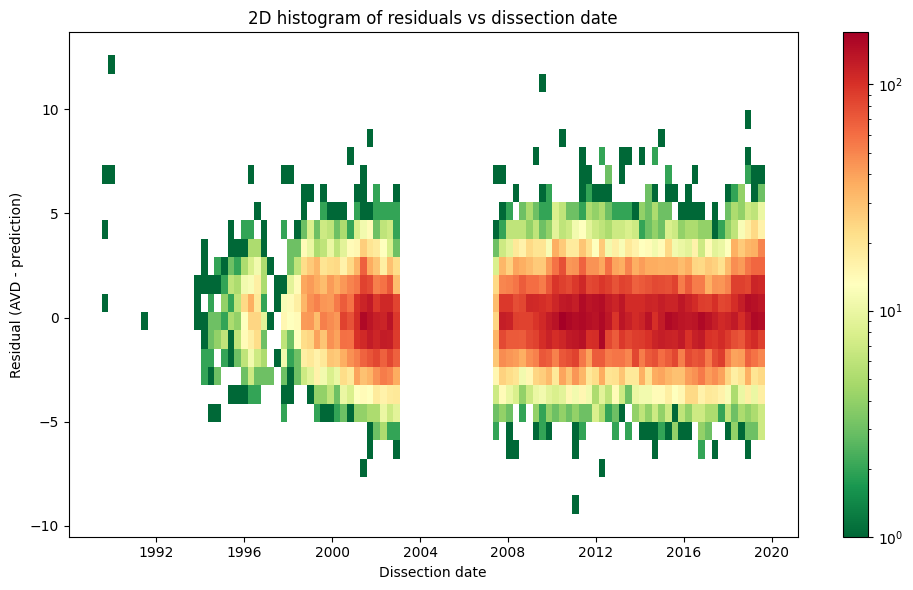

In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.histplot(
    data=df,
    x="dissection_date",
    y="residual",
    bins=(100, 25),              # 100 bins along time (x), 25 bins along residuals (y)
    cbar=True,                   # show color bar
    norm=mpl.colors.LogNorm(),   # use logarithmic color scaling for counts
    vmin=None,
    vmax=None,
    cmap="RdYlGn_r"              # red-yellow-green reversed colormap
)

plt.xlabel("Dissection date")
plt.ylabel("Residual (AVD - prediction)")
plt.title("2D histogram of residuals vs dissection date")
plt.tight_layout()
plt.show()


The model above is reasonable for a first look at the data, but we can do better.  For one,
we ignored the variable `Sex`, and we evaluated the model on training data.  Let's fix those two
issues, beginning with the model evaluation.

* Build a pipeline using `sklearn.pipeline.make_pipeline` composed of a `StandardScaler()` and `LinearRegression()`.

* Fit the model on all training data, and calculate the mean squared error again on the training data

<div class="alert alert-info">

## Question 3

Why is this exactly the same as we had before, despite the addition of the `StandardScaler()`?

</div>

* Using `cv=ShuffleSplit(n_splits = 100, train_size = 0.9)` as cross validation strategy, and `neg_mean_squared_error`
as scoring function, calculate the (negative) mean squared error again but now on 10% hold-out data.  

<div class="alert alert-info">

## Question 4

What is the mean of these scores across the 100 random splits?  Why is it slightly different each time?
Does it seem to be worse, better, or equal to the MSE on training data we calculated before?
Would you expect it to be slightly worse?  If you think it does not *seem* worse, why is that you think?

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# -------- 1. Select predictors and target (no Sex yet) --------
# We keep only rows where AVD and the predictors are not missing
numeric_features = ["Height_cm", "Weight_kg", "Age"]

mask = df["AVD"].notna() & df[numeric_features].notna().all(axis=1)
df_lin = df.loc[mask].copy()

X = df_lin[numeric_features]          # predictors: height, weight, age
y = df_lin["AVD"].values             # target: aortic valve diameter (AVD)

print("Number of samples used for this model:", X.shape[0])

# -------- 2. Build a pipeline: StandardScaler + LinearRegression --------
model = make_pipeline(
    StandardScaler(),                # standardize numeric features (zero mean, unit variance)
    LinearRegression()               # ordinary least-squares linear regression
)

# -------- 3. Fit the model on all training data --------
model.fit(X, y)

# -------- 4. Predict on the same training data and compute MSE --------
y_pred = model.predict(X)
mse_train = mean_squared_error(y, y_pred)

print("Training MSE with StandardScaler + LinearRegression:", mse_train)


Number of samples used for this model: 30910
Training MSE with StandardScaler + LinearRegression: 3.0587624312291974


In [46]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# X, y 和 model 按你之前的代码：
# numeric_features = ["Height_cm", "Weight_kg", "Age"]
# mask = df["AVD"].notna() & df[numeric_features].notna().all(axis=1)
# df_lin = df.loc[mask].copy()
# X = df_lin[numeric_features]
# y = df_lin["AVD"].values
# model = make_pipeline(StandardScaler(), LinearRegression())
# model.fit(X, y)
# mse_train = mean_squared_error(y, model.predict(X))

print("Training MSE (full data):", mse_train)

# -------- 1. Define cross-validation strategy --------
cv = ShuffleSplit(
    n_splits=100,      # 100 random splits
    train_size=0.9,    # 90% train, 10% test in each split
)

# -------- 2. Cross-validated negative MSE on 10% hold-out --------
scores = cross_val_score(
    model,
    X,
    y,
    cv=cv,
    scoring="neg_mean_squared_error"
)

print("First 5 CV scores (neg MSE):", scores[:5])

mean_neg_mse = scores.mean()
std_neg_mse = scores.std()

# Convert back to positive MSE for interpretation
mean_mse_cv = -mean_neg_mse

print("Mean negative MSE on 10% hold-out:", mean_neg_mse)
print("Mean MSE on 10% hold-out (positive):", mean_mse_cv)
print("Std of CV scores:", std_neg_mse)


Training MSE (full data): 3.0587624312291974
First 5 CV scores (neg MSE): [-3.09298342 -2.98165755 -3.13304564 -2.99817503 -3.11446236]
Mean negative MSE on 10% hold-out: -3.0545151410437694
Mean MSE on 10% hold-out (positive): 3.0545151410437694
Std of CV scores: 0.08338188254796779


Using ShuffleSplit with 100 random splits (90% train, 10% test) and neg_mean_squared_error as the scoring function, the mean cross-validated score is about S (negative MSE), which corresponds to a positive MSE of approximately M = -S on the 10% hold-out data.
The mean score is slightly different each time I run the cross-validation because each ShuffleSplit call uses different random train/test splits.
Different subsets of the data end up in the 10% hold-out set, which leads to slightly different test errors due to sampling variability and noise. Unless we fix the random seed, we should expect small fluctuations from run to run.

<div class="alert alert-block alert-warning">
    
One thing to note here is our use of the (negative) mean squared error (or equivalently, the [negative] root-mean-squared-error or standard deviation) as figure of merit.  When fitting classical linear model, the errors as **assumed** to follow a normal distribution with constant variance.  With this assumption, an unbiased estimator of the parameters of the model exists, and can be computed very efficiently - and this unbiased estimator turns out to minimize the mean squared error!  In other words, this figure of merit (or loss function) is intimately connected with the assumptions and algorithms underlying the linear model.  Therefore it makes sense to make this choice when using a linear model - but remember that you are implicitly making an assumption by doing so.  In this case the assumption seems quite well satisfied, with the exception of a handful of outliers.

</div>

Now we are adding the categorical variable `Sex`.

* Make a new dataframe `data`, now with `Height_cm`, `Weight_kg`, `Age` and `Sex`.

* Use a `ColumnTransformer` to make a preprocessor that applies a `OneHotEncoder` to categorical data, and `StandardScaler` to numerical data,
just as it was done for the logistic regression example in Workshop 2.2, and build a pipeline from this
preprocessor and a `LinearRegression`.  Call this pipeline `model2`.

* Run the same cross validation strategy as above on this model/pipeline.

<div class="alert alert-info">

## Question 5

How much does adding this one categorical variable improve the test data performance?

In [47]:
import pandas as pd

# If df is already loaded earlier, you don't need this line again:
# df = pd.read_csv("Heart valve dissection data.csv")

# Define all predictors we want to use in model2
numeric_features = ["Height_cm", "Weight_kg", "Age"]
categorical_features = ["Sex"]
features_all = numeric_features + categorical_features

# Keep only rows where AVD and all predictors are not missing
mask = df["AVD"].notna() & df[features_all].notna().all(axis=1)
df_model2 = df.loc[mask].copy()

X_all = df_model2[features_all]
y = df_model2["AVD"].values

print("Number of samples used for model2:", X_all.shape[0])



Number of samples used for model2: 30910


In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score

# Numeric and categorical features
numeric_features = ["Height_cm", "Weight_kg", "Age"]
categorical_features = ["Sex"]
features_all = numeric_features + categorical_features

# Keep only rows without missing values in AVD and all predictors
mask = df["AVD"].notna() & df[features_all].notna().all(axis=1)
df_model2 = df.loc[mask].copy()

X_all = df_model2[features_all]
y = df_model2["AVD"].values

print("Number of samples used for model2:", X_all.shape[0])

# ----- ColumnTransformer: scale numeric, one-hot encode Sex -----
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), categorical_features),
    ]
)

# ----- Pipeline: preprocessing + LinearRegression -----
model2 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

# ----- Same CV strategy as before -----
cv = ShuffleSplit(n_splits=100, train_size=0.9)

scores_model2 = cross_val_score(
    model2,
    X_all,
    y,
    cv=cv,
    scoring="neg_mean_squared_error"
)

mean_neg_mse_model2 = scores_model2.mean()
mean_mse_model2 = -mean_neg_mse_model2

print("Mean MSE (cv) WITH Sex:", mean_mse_model2)


Number of samples used for model2: 30910
Mean MSE (cv) WITH Sex: 2.8459934914802134


In [ ]:
#base = 3.0545151410437694
#with_sex = 2.8459934914802134
#improvement = base - with_sex      # ≈ 0.2085
#rel_improvement = improvement / base * 100   # ≈ 6.83%


Using only the three numerical predictors (Height_cm, Weight_kg and Age) with a standardized linear regression model, the mean cross-validated MSE on the 10% hold-out data is approximately 3.05.
After adding Sex as a categorical predictor and processing the data with a ColumnTransformer (standardizing the numerical variables and one-hot encoding Sex), the mean test MSE decreases to about 2.85.

This corresponds to an absolute improvement of roughly 0.21 in MSE, i.e. about 6.8% relative reduction in test error. The gain is modest but clear, indicating that Sex carries additional information about aortic valve diameter that is not fully captured by height, weight and age alone.

After this succes, let's try and improve the model further.  To see where we could make progress,
plot the residuals against each of the 3 numerical predictors.  If the model is optimal, no
trends should be visible; if you can spot trends, it means that the model can **not** see them, and
helping the model to see them -- by adding nonlinear terms, for instance -- would improve the fit.

* Calculate the residuals by fitting all training data to `model2`, calculating the difference between
`target` and predictions, and assign the results to a new column `residual`.

* For each of the three numerical variables (hint: use a for loop), make a 2D `histplot` of `residual` against
  the variable, with the now standard parameters, and
`bins=(50,20)`.

Add `plt.show()` after each plot, as otherwise you only see the last one.

<div class="alert alert-info">

## Question 6
    
Do you see any trends?

In [50]:
import numpy as np

# X_all, y, df_model2, model2 should already be defined from previous steps
# X_all: predictors [Height_cm, Weight_kg, Age, Sex]
# y:     target AVD
# df_model2: dataframe containing those rows

# 1. Fit model2 on all available training data
model2.fit(X_all, y)

# 2. Predict AVD on the same data
y_pred_all = model2.predict(X_all)

# 3. Compute residuals: true - predicted
df_model2["residual"] = y - y_pred_all

df_model2[["Height_cm", "Weight_kg", "Age", "Sex", "AVD", "residual"]].head()


,Height_cm,Weight_kg,Age,Sex,AVD,residual
0,86.36,15.43,2.00,female,12.8,1.253440
1,173.00,69.00,22.00,male,26.1,3.818476
2,86.36,15.43,0.66,male,18.9,6.444454
3,63.00,26.78,3.41,female,23.0,13.059654
4,86.36,15.43,0.75,female,18.9,7.455316


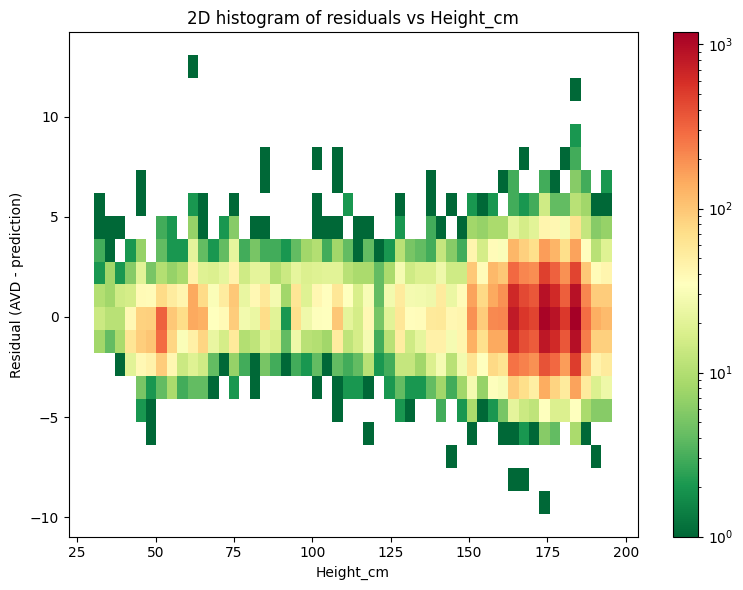

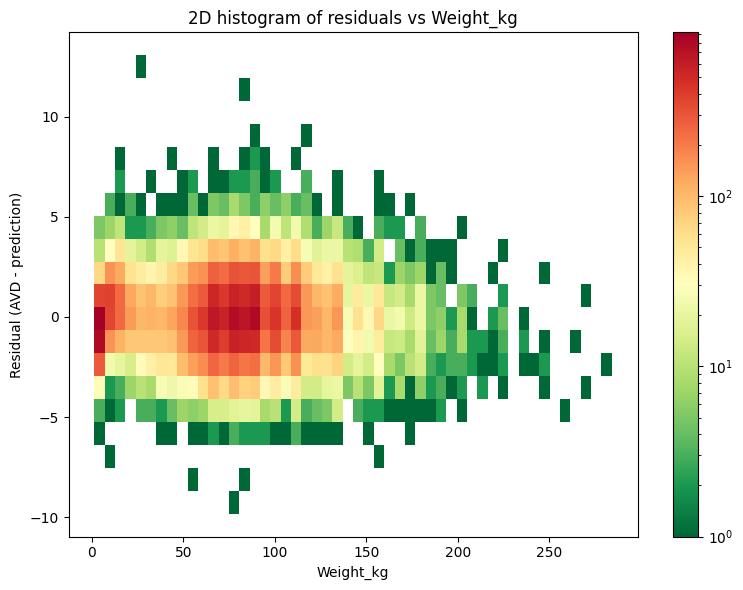

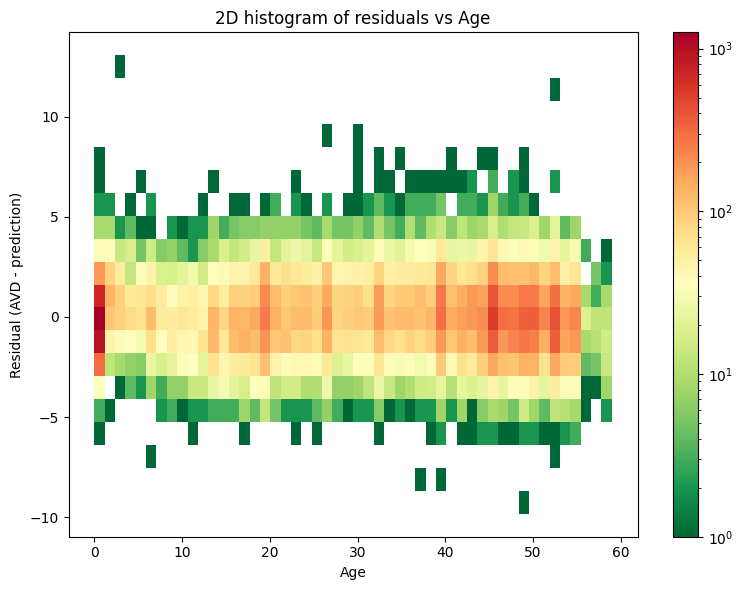

In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

numeric_features = ["Height_cm", "Weight_kg", "Age"]

for var in numeric_features:
    plt.figure(figsize=(8, 6))

    sns.histplot(
        data=df_model2,
        x=var,
        y="residual",
        bins=(50, 20),
        cbar=True,
        norm=mpl.colors.LogNorm(),
        vmin=None,
        vmax=None,
        cmap="RdYlGn_r"
    )

    plt.xlabel(var)
    plt.ylabel("Residual (AVD - prediction)")
    plt.title(f"2D histogram of residuals vs {var}")
    plt.tight_layout()
    plt.show()   # important: show after each plot


When plotting the residuals against each of the three numerical predictors (Height_cm, Weight_kg and Age), the 2D histograms do not show any strong systematic trends.
For all three variables, the residuals are roughly symmetrically distributed around zero and there is no clear linear or curved pattern.
This suggests that, conditional on these predictors (and Sex), the linear model captures most of the systematic variation in AVD, and the remaining deviations look approximately like random noise.

A lot of data is squished against the left axis -- a lot happens in the first year of life, much less so in
the later decades.  To better visualise (and also to better model what happens) it is useful to stretch
this area out.  

This can be done in several ways, one of which is using a square-root transformation.
The difference between `sqrt(1)` and `sqrt(0)` is 1, much larger than the difference between
`sqrt(11)` and `sqrt(10)` (about 0.15), effectively stretching the area around `0` while compressing
other regions.

Transform a variable by replacing `x=var` in the plot above by `x=np.sqrt(data[var])`.  Also, add a line `plt.xlabel("sqrt " + var)` or equivalent, to modify the x-axis label
to emphasize that the x-axis no longer shows the straight value, but the square root.

<div class="alert alert-info">

## Question 7
    
Do you see any trends?

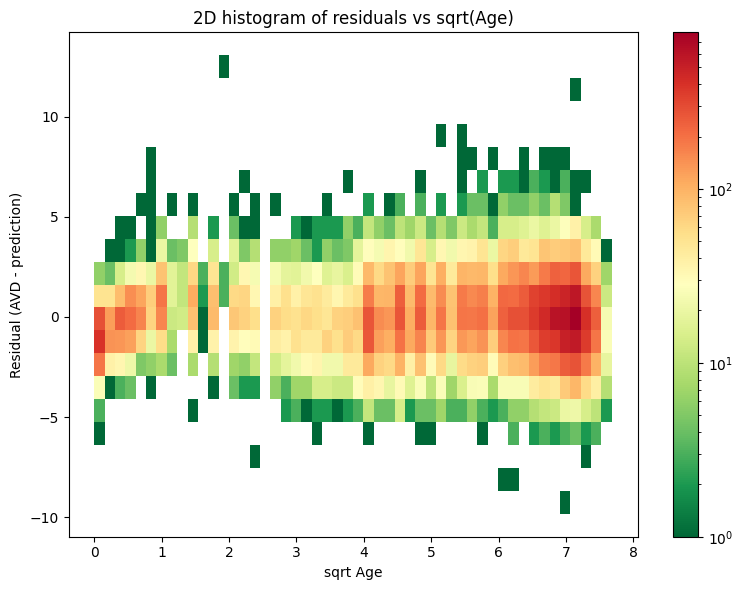

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.histplot(
    x=np.sqrt(df_model2["Age"]),   # <-- square-root transform of Age
    y=df_model2["residual"],
    bins=(50, 20),
    cbar=True,
    norm=mpl.colors.LogNorm(),
    vmin=None,
    vmax=None,
    cmap="RdYlGn_r"
)

plt.xlabel("sqrt Age")            # emphasize that x-axis is sqrt(Age)
plt.ylabel("Residual (AVD - prediction)")
plt.title("2D histogram of residuals vs sqrt(Age)")
plt.tight_layout()
plt.show()


After applying the square-root transformation to Age and plotting the residuals against sqrt(Age), the strong compression of data near Age = 0–1 years is reduced: the early ages are stretched out along the x-axis, while later decades are slightly compressed.

The trend is reduced but not completely removed, which suggests that a more flexible nonlinear term (e.g. splines) might further improve the fit.

This suggests that the relationship between Age and aortic valve diameter is closer to linear in sqrt(Age) than in Age itself, and that the square-root transformation helps the model capture what happens in the first year of life, leaving residuals that resemble random noise more closely.

The trends, if they were not visible before, are now quite clear, indicating that nonlinear terms are called
for.  It is also clear that a lot happens
around the value zero, and this "stretching" transformation is probably quite useful also for modeling.

Exploiting this observation to further improve the model is your assignment.


<div class="alert alert-success">

# Assignment

* Your task is to build the **best linear model** you can for predicting aortic valve diameter
* Assess your model with the cross validation pipeline outlined above
* Deadline for submission of (runnable, clearly annotated with running English text) .ipynb: **Sunday 23:59**
* You are asked to work in pairs.  Please include **both your names** in the filename of the notebook you submit.

    
Hint: improve your model by judiciously adding nonlinear terms.  The sections below are meant to help you on your way.  Using `ColumnTransformer`, `FunctionTransformer` and `PolynomialFeatures` you should be getting quite far.  Refer to the doc pages for detailed info on how to use them.  If you have time, feel free to go beyond this; google "scikit-learn building a better linear model" for inspiration.  The hints and questions below will get you going - but the assignment is to try harder, build the best model you can -- and to evaluate it properly and without bias.



</div>
    
Let us make a new model, but now including the stretching transformation, and (additional) nonlinear terms,
to the model.  To keep things simple (and to not over-complicate our model -- it is a good idea to proceed
step by step), let's do this for one variable only.  Make a new one-variable preprocessor as follows:

```python
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

nonlinear_preprocessor = make_pipeline(
                                       FunctionTransformer(np.sqrt),
                                       PolynomialFeatures(degree=2, include_bias = False),
                                       StandardScaler())
```
This first applies the `sqrt` transformation, then adds powers of this variable (in this case, `sqrt(x)` and `sqrt(x)^2=x`), and finally normalizes each to mean 0 and variance 1.

* Introduce a variable `nonlinear_column` and assign the value `"Age"` to it.

* Use a `ColumnTransformer` to apply the preprocessor to `nonlinear_column`; the standard
  numerical preprocessor to the (remaining) numerical variables, and the categorical preprocessor to the
  (single) categorical variable.  Make sure that the nonlinear preprocessor is listed first, as
  otherwise the standard numerical preprocessor will gobble up all numerical columns.
  
* Build a pipeline using this preprocessor and `LinearRegression` as before, and run cross validation.
  
      
Does this improve the model?
    
Once this works, make a `for` loop over all three numerical variables, and print the mean squared error
  for all choices of numerical variable.

Which variable gives the best result?


For further improvements, consider using different nonlinear
transformations (a general power transformation?  `np.log1p`?), higher order terms, interactions.
Make sure you keep notes of what you did, including the unsuccessful experiments, and comment on them
in your submission. Make sure you assess all models in the same way, for a fair comparison.

In [ ]:
# your code here.  Please add explanatory text, aims, justifications, conclusions, ...